In [1]:
import tensorflow as tf
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt

In [2]:
train_noisy_dir = 'C:\\Users\\xoryt\\OneDrive\\Documents\\info\\Hackatons\\ML&AI Electron\\train_noisy'
train_clear_dir = 'C:\\Users\\xoryt\\OneDrive\\Documents\\info\\Hackatons\\ML&AI Electron\\train'
test_noisy_dir = 'C:\\Users\\xoryt\\OneDrive\\Documents\\info\\Hackatons\\ML&AI Electron\\val_noisy'
test_clear_dir = 'C:\\Users\\xoryt\\OneDrive\\Documents\\info\\Hackatons\\ML&AI Electron\\val_noisy'

In [3]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(rescale=1./255)

seed = 1

# Load images in batches from the training directories
train_noisy_gen = datagen.flow_from_directory(
    train_noisy_dir,
    target_size=(400, 400),
    batch_size=32,
    class_mode=None,
    seed=seed)

train_clear_gen = datagen.flow_from_directory(
    train_clear_dir,
    target_size=(400, 400),
    batch_size=32,
    class_mode=None,
    seed=seed)

# Load images in batches from the testing directories
test_noisy_gen = datagen.flow_from_directory(
    test_noisy_dir,
    target_size=(400, 400),
    batch_size=32,
    class_mode=None,
    seed=seed)

test_clear_gen = datagen.flow_from_directory(
    test_clear_dir,
    target_size=(400, 400),
    batch_size=32,
    class_mode=None,
    seed=seed)

Found 3499 images belonging to 1 classes.
Found 3499 images belonging to 1 classes.
Found 501 images belonging to 1 classes.
Found 501 images belonging to 1 classes.


(32, 400, 400, 3)
(32, 400, 400, 3)
(32, 400, 400, 3)
(32, 400, 400, 3)
(32, 400, 400, 3)
(32, 400, 400, 3)
(32, 400, 400, 3)
(32, 400, 400, 3)


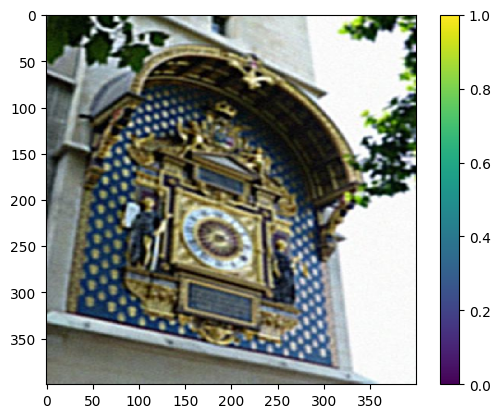

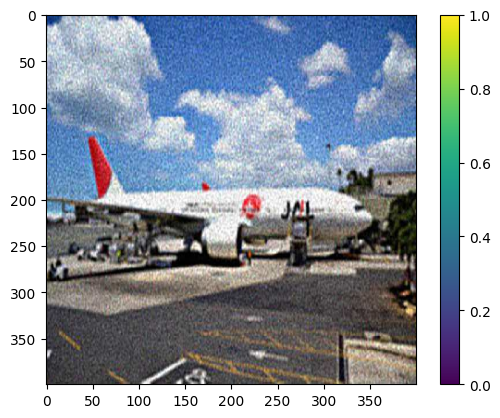

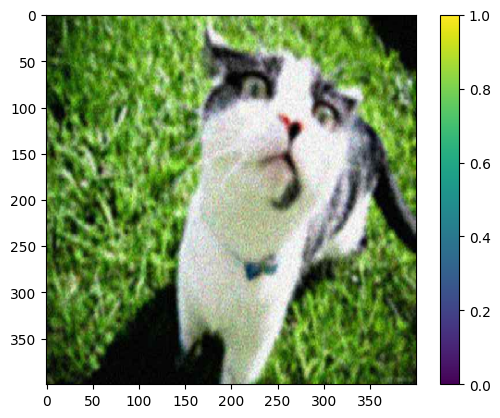

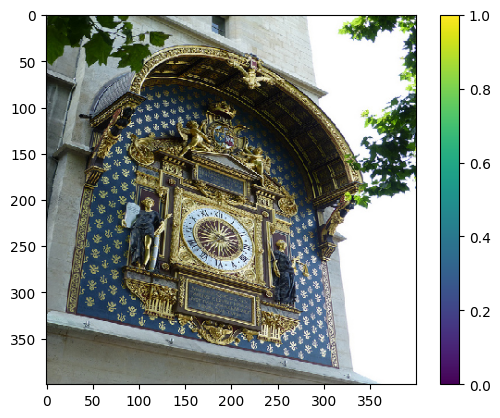

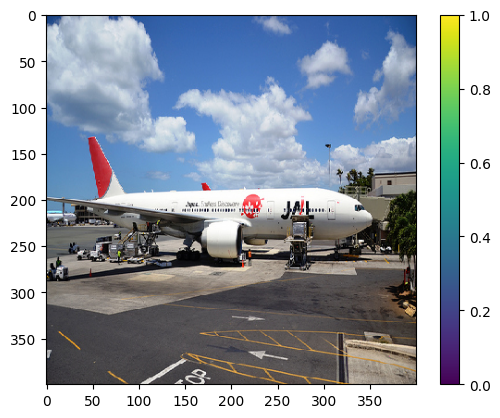

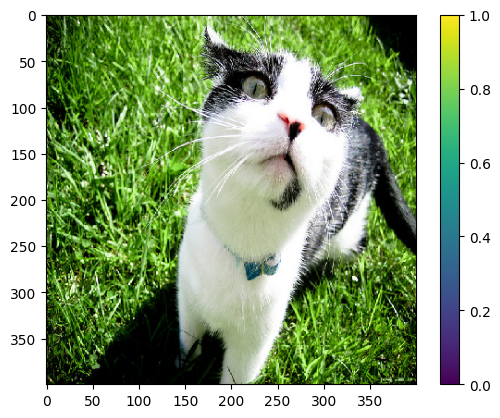

In [4]:
for idx, img in enumerate(train_noisy_gen):
    print(img.shape)
    if idx == 3:
        break
    plt.figure()
    plt.imshow(img[0])
    plt.colorbar()

for idx, img in enumerate(train_clear_gen):
    print(img.shape)
    if idx == 3:
        break
    plt.figure()
    plt.imshow(img[0])
    plt.colorbar()

In [5]:
def train_generator():
    while True:
        noisy_batch = next(train_noisy_gen)
        clear_batch = next(train_clear_gen)

        # Normalize the images to be in the range [0, 1]
        # noisy_batch = noisy_batch.astype('float32') - 0.5
        # clear_batch = clear_batch.astype('float32') - 0.5

        yield (noisy_batch, clear_batch)


In [6]:
# Define the input shape
input_img = Input(shape=(400, 400, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
autoencoder.summary()

In [7]:
autoencoder.fit(
    x=train_generator(),
    steps_per_epoch=30, #steps_per_epoch
    epochs=10)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - loss: 0.0689
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - loss: 0.0203
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - loss: 0.0137
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - loss: 0.0115
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - loss: 0.0105
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - loss: 0.0098
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - loss: 0.0095
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - loss: 0.0091
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - loss: 0.0086
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - loss: 0.0091


In [8]:
def calculate_psnr(img1, img2):
    # Ensure the images are float type
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Calculate MSE
    mse = np.mean((img1 - img2)**2)

    # If MSE is zero, PSNR is infinity
    if mse == 0:
        return float('inf')

    # Calculate MAX_I
    max_i = np.max(img1)

    # Calculate PSNR
    return 20 * np.log10(max_i) - 10 * np.log10(mse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.6312043 , 0.67677104, 0.68069303, ..., 0.74447   , 0.7180805 ,
        0.6123849 ],
       [0.6481977 , 0.709004  , 0.7071442 , ..., 0.75624096, 0.74041617,
        0.6580713 ],
       [0.69306886, 0.76487714, 0.76256907, ..., 0.79734075, 0.78158975,
        0.6961807 ],
       ...,
       [0.42574114, 0.40562522, 0.39460984, ..., 0.39661446, 0.40329337,
        0.41788018],
       [0.44925946, 0.41555294, 0.37912786, ..., 0.36921567, 0.3842534 ,
        0.39714262],
       [0.4691467 , 0.46355197, 0.42101926, ..., 0.40394446, 0.42777762,
        0.41199493]], dtype=float32)

array([[0.6289916 , 0.6914442 , 0.7157133 , ..., 0.7566404 , 0.71922654,
        0.6186577 ],
       [0.6975822 , 0.74674195, 0.7701192 , ..., 0.82094884, 0.78012043,
        0.68746096],
       [0.7206911 , 0.77487415, 0.7875642 , ..., 0.83264524, 0.79638076,
        0.7098598 ],
       ...,
       [0.45922637, 0.4587984 , 0.4503608 , ..., 0.4604989 , 0.44207567,
        0.47185212],
       [0.4824796 , 0.47722378, 0.46774077, ..., 0.43803984, 0.423632  ,
        0.45551392],
       [0.47693986, 0.4513615 , 0.4463148 , ..., 0.4109084 , 0.4020099 ,
        0.45558378]], dtype=float32)

array([[0.6872633 , 0.7664442 , 0.77804756, ..., 0.7736868 , 0.7442455 ,
        0.65595526],
       [0.7314084 , 0.8364728 , 0.84247404, ..., 0.8527647 , 0.8361623 ,
        0.732592  ],
       [0.7539329 , 0.8571653 , 0.8686767 , ..., 0.88668764, 0.8779581 ,
        0.7864242 ],
       ...,
       [0.4877585 , 0.518903  , 0.51277816, ..., 0.45938283, 0.48825377,
        0.46095395],
       [0.49134842, 0.5082242 , 0.5072416 , ..., 0.4508675 , 0.4678552 ,
        0.44742274],
       [0.50915354, 0.5111978 , 0.514958  , ..., 0.45076182, 0.4467752 ,
        0.42965814]], dtype=float32)

(400, 400, 3)
0.020233052
0.9556932
21.85378744785004


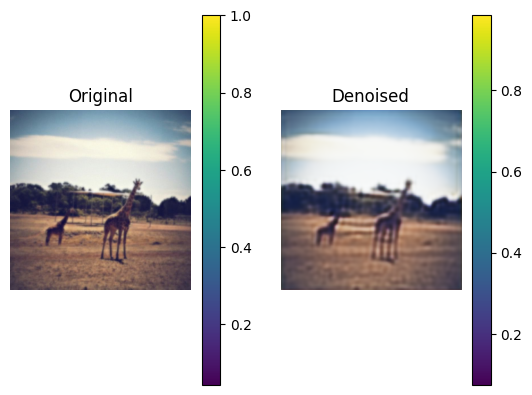

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.42030203, 0.38667926, 0.35894787, ..., 0.22053085, 0.22040582,
        0.2850389 ],
       [0.38674122, 0.37817663, 0.3521147 , ..., 0.21228325, 0.22430761,
        0.2534082 ],
       [0.3627459 , 0.36976415, 0.36159188, ..., 0.20263486, 0.19847909,
        0.22331074],
       ...,
       [0.2219444 , 0.15191126, 0.12391769, ..., 0.32171452, 0.33459502,
        0.33027482],
       [0.26551148, 0.19251087, 0.1504626 , ..., 0.2858248 , 0.30685192,
        0.31893417],
       [0.34728813, 0.32136685, 0.23623033, ..., 0.33896226, 0.37730166,
        0.3560519 ]], dtype=float32)

array([[0.38239348, 0.32066944, 0.3062995 , ..., 0.23333597, 0.2262933 ,
        0.2905985 ],
       [0.31751058, 0.27895522, 0.27857205, ..., 0.1975094 , 0.17808463,
        0.2812955 ],
       [0.29957116, 0.26045597, 0.2607833 , ..., 0.17378204, 0.14156173,
        0.23351423],
       ...,
       [0.18633176, 0.11165657, 0.0990652 , ..., 0.22124562, 0.20059341,
        0.33060905],
       [0.2272822 , 0.14934994, 0.13432053, ..., 0.21250266, 0.2048208 ,
        0.32777882],
       [0.2930233 , 0.19324297, 0.17548382, ..., 0.2498015 , 0.24941567,
        0.36846814]], dtype=float32)

array([[0.33501634, 0.2532963 , 0.22715078, ..., 0.18729323, 0.19917142,
        0.2714018 ],
       [0.25226232, 0.17078175, 0.14651744, ..., 0.08555254, 0.10401341,
        0.17328694],
       [0.23757553, 0.15768018, 0.14139573, ..., 0.08928903, 0.09878229,
        0.14321359],
       ...,
       [0.13109025, 0.0835634 , 0.07404899, ..., 0.15178952, 0.18085553,
        0.23897651],
       [0.16013955, 0.10609524, 0.08945423, ..., 0.15763846, 0.19265875,
        0.25250682],
       [0.28070256, 0.20136157, 0.16821194, ..., 0.21469489, 0.24151212,
        0.30168608]], dtype=float32)

(400, 400, 3)
0.011544152
0.8498976
25.94241815189371


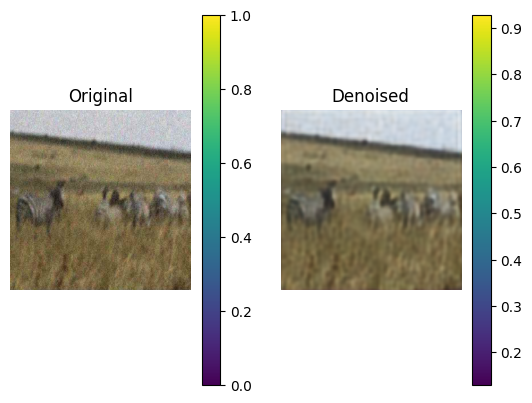

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.676247  , 0.7421582 , 0.75343347, ..., 0.82472026, 0.79274887,
        0.6604165 ],
       [0.7046569 , 0.7875426 , 0.79435796, ..., 0.84903413, 0.8267848 ,
        0.7214232 ],
       [0.75804174, 0.8468948 , 0.8535606 , ..., 0.8915199 , 0.8719211 ,
        0.7685019 ],
       ...,
       [0.29577726, 0.22802953, 0.20420034, ..., 0.39130595, 0.40604395,
        0.43390203],
       [0.32561752, 0.26034418, 0.2278032 , ..., 0.3569101 , 0.37917712,
        0.40643018],
       [0.38320288, 0.35187936, 0.29845724, ..., 0.39250365, 0.4237724 ,
        0.41453195]], dtype=float32)

array([[0.6693147 , 0.7476431 , 0.7770995 , ..., 0.81704116, 0.7770715 ,
        0.65815276],
       [0.7567242 , 0.81766313, 0.8474246 , ..., 0.8855154 , 0.8457806 ,
        0.7417587 ],
       [0.7826823 , 0.8460885 , 0.86484313, ..., 0.89795697, 0.8633958 ,
        0.77144533],
       ...,
       [0.28466162, 0.23076864, 0.21532825, ..., 0.48485476, 0.47275916,
        0.49512303],
       [0.31751436, 0.25700042, 0.2410039 , ..., 0.4517716 , 0.44003734,
        0.471874  ],
       [0.3662528 , 0.28852692, 0.27834687, ..., 0.41111338, 0.40387884,
        0.46192473]], dtype=float32)

array([[0.72600144, 0.8115531 , 0.82744586, ..., 0.81860876, 0.7869719 ,
        0.69336194],
       [0.78002685, 0.8847112 , 0.8947496 , ..., 0.9000002 , 0.88230366,
        0.78348666],
       [0.8006569 , 0.90121245, 0.91509956, ..., 0.92459065, 0.9153784 ,
        0.835531  ],
       ...,
       [0.26574308, 0.23759158, 0.23504817, ..., 0.5567722 , 0.5858136 ,
        0.5269497 ],
       [0.28796142, 0.25234395, 0.23964122, ..., 0.5171133 , 0.5343949 ,
        0.49104217],
       [0.37924823, 0.3329988 , 0.30885914, ..., 0.4882667 , 0.48547035,
        0.455219  ]], dtype=float32)

(400, 400, 3)
0.0043070903
0.9899921
23.74049662819177


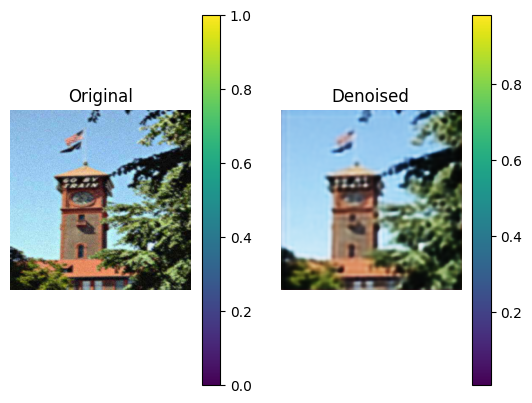

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


array([[0.47110522, 0.45090136, 0.42951217, ..., 0.33744615, 0.34261912,
        0.37737417],
       [0.45422798, 0.45226482, 0.4264019 , ..., 0.355314  , 0.3704458 ,
        0.3713207 ],
       [0.44668832, 0.46018267, 0.44673958, ..., 0.3646394 , 0.37047595,
        0.36604446],
       ...,
       [0.35103348, 0.2965341 , 0.26820529, ..., 0.43702757, 0.42875412,
        0.39241308],
       [0.36514997, 0.30866867, 0.26689354, ..., 0.40622658, 0.40080288,
        0.37886336],
       [0.41264573, 0.38974625, 0.32778615, ..., 0.4256682 , 0.4359208 ,
        0.3994974 ]], dtype=float32)

array([[0.44271424, 0.4092407 , 0.40264237, ..., 0.30526814, 0.31126964,
        0.37011123],
       [0.4081864 , 0.38315827, 0.38848096, ..., 0.2884551 , 0.28100476,
        0.37609565],
       [0.40044487, 0.3834108 , 0.38716456, ..., 0.26717678, 0.25188786,
        0.35596827],
       ...,
       [0.3184185 , 0.25437537, 0.24059899, ..., 0.31670573, 0.28624135,
        0.38250604],
       [0.34767723, 0.27920356, 0.26081032, ..., 0.3145757 , 0.29229802,
        0.37760705],
       [0.37947354, 0.3033967 , 0.28850543, ..., 0.33728275, 0.32850808,
        0.40599063]], dtype=float32)

array([[0.4326015 , 0.38511902, 0.3652046 , ..., 0.23845705, 0.2607356 ,
        0.34361064],
       [0.38294598, 0.33501375, 0.3075228 , ..., 0.1376465 , 0.17109683,
        0.26485705],
       [0.37514564, 0.33207294, 0.3164285 , ..., 0.13515155, 0.1626558 ,
        0.24420044],
       ...,
       [0.26892418, 0.21793525, 0.20541094, ..., 0.2267765 , 0.24220398,
        0.29668698],
       [0.2909961 , 0.23365654, 0.2115143 , ..., 0.23529838, 0.25818738,
        0.30650863],
       [0.3699454 , 0.3077272 , 0.2798428 , ..., 0.2807003 , 0.29347053,
        0.34104827]], dtype=float32)

(400, 400, 3)
0.006942878
0.9759284
27.322497137119765


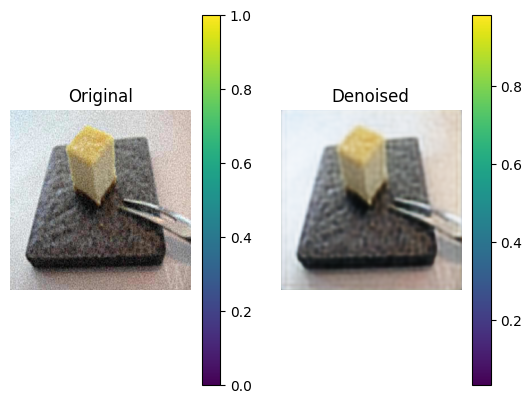

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.37269273, 0.31731093, 0.2921246 , ..., 0.505201  , 0.4942237 ,
        0.45974895],
       [0.33473995, 0.28266245, 0.26055878, ..., 0.5263868 , 0.54219455,
        0.4694915 ],
       [0.3086315 , 0.26045403, 0.24372098, ..., 0.56561327, 0.5714931 ,
        0.48902217],
       ...,
       [0.17617643, 0.10418779, 0.07880871, ..., 0.08519759, 0.11088728,
        0.15218638],
       [0.22341272, 0.14652972, 0.10960912, ..., 0.09627589, 0.1263645 ,
        0.17261676],
       [0.31409812, 0.27812678, 0.19437762, ..., 0.177766  , 0.23545216,
        0.24267967]], dtype=float32)

array([[0.37649953, 0.32673404, 0.31659782, ..., 0.33603656, 0.33736745,
        0.37878296],
       [0.3090681 , 0.27197632, 0.2608989 , ..., 0.3132447 , 0.2985707 ,
        0.38060483],
       [0.29260102, 0.26070237, 0.25316885, ..., 0.2666128 , 0.24599475,
        0.3535957 ],
       ...,
       [0.15668681, 0.08430441, 0.07085992, ..., 0.059002  , 0.0536682 ,
        0.17429355],
       [0.19636238, 0.11524975, 0.10036263, ..., 0.06447399, 0.0640346 ,
        0.19911897],
       [0.26905513, 0.15996255, 0.14545314, ..., 0.10634696, 0.10662051,
        0.26326144]], dtype=float32)

array([[0.39622587, 0.35534182, 0.3322041 , ..., 0.25131842, 0.27655286,
        0.37421232],
       [0.31423146, 0.2788322 , 0.25330406, ..., 0.14656602, 0.18974905,
        0.30039144],
       [0.30986592, 0.2759215 , 0.26164305, ..., 0.14206745, 0.180451  ,
        0.29080722],
       ...,
       [0.12082277, 0.08275658, 0.07278623, ..., 0.08434074, 0.10882321,
        0.13106956],
       [0.14768764, 0.10335589, 0.08706494, ..., 0.08931834, 0.12406714,
        0.15968321],
       [0.2728443 , 0.199686  , 0.16522619, ..., 0.1401028 , 0.17416763,
        0.21456847]], dtype=float32)

(400, 400, 3)
0.019597324
0.9215958
25.866445937586242


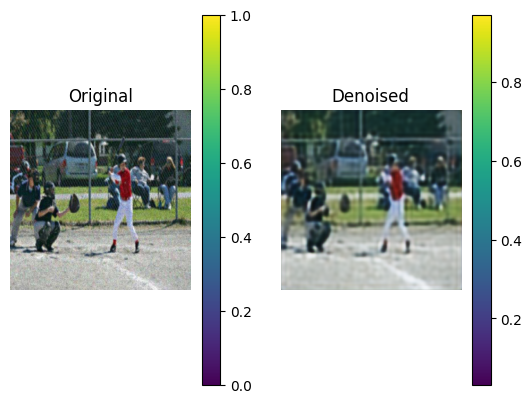

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


array([[0.5360878 , 0.53827083, 0.52865666, ..., 0.72590566, 0.69346154,
        0.5947801 ],
       [0.53175205, 0.5406945 , 0.52386564, ..., 0.7372873 , 0.7192295 ,
        0.6347488 ],
       [0.544954  , 0.5583751 , 0.54144925, ..., 0.77036875, 0.7545105 ,
        0.66754   ],
       ...,
       [0.6315009 , 0.70182484, 0.7067288 , ..., 0.6245985 , 0.62086993,
        0.5567474 ],
       [0.5979777 , 0.6621664 , 0.65833926, ..., 0.5654345 , 0.5652747 ,
        0.5097684 ],
       [0.575711  , 0.63754636, 0.63382536, ..., 0.53823745, 0.54384536,
        0.48339924]], dtype=float32)

array([[0.5362741 , 0.5571098 , 0.5660175 , ..., 0.710348  , 0.6770143 ,
        0.5860136 ],
       [0.5516451 , 0.5733982 , 0.575529  , ..., 0.7694043 , 0.7317825 ,
        0.6453364 ],
       [0.5598015 , 0.58495295, 0.5770353 , ..., 0.77264684, 0.7371389 ,
        0.66157687],
       ...,
       [0.6818044 , 0.72608703, 0.7387215 , ..., 0.632868  , 0.6149995 ,
        0.587209  ],
       [0.67610294, 0.72423285, 0.74738216, ..., 0.61256   , 0.58318007,
        0.55120385],
       [0.5823625 , 0.6223253 , 0.62983483, ..., 0.5310738 , 0.51113063,
        0.5182212 ]], dtype=float32)

array([[0.5814041 , 0.6289504 , 0.62992203, ..., 0.6861809 , 0.663907  ,
        0.60993576],
       [0.5899149 , 0.656783  , 0.651188  , ..., 0.742986  , 0.7308968 ,
        0.66026187],
       [0.60467434, 0.6758354 , 0.67508996, ..., 0.7708438 , 0.76790303,
        0.7021025 ],
       ...,
       [0.6634529 , 0.7250171 , 0.75464755, ..., 0.61188143, 0.63204515,
        0.59103453],
       [0.6555691 , 0.71794623, 0.75091374, ..., 0.5950039 , 0.599964  ,
        0.55138814],
       [0.60350513, 0.6340488 , 0.67422324, ..., 0.53470963, 0.51780456,
        0.48550197]], dtype=float32)

(400, 400, 3)
0.012331749
0.97031534
25.634643890724654


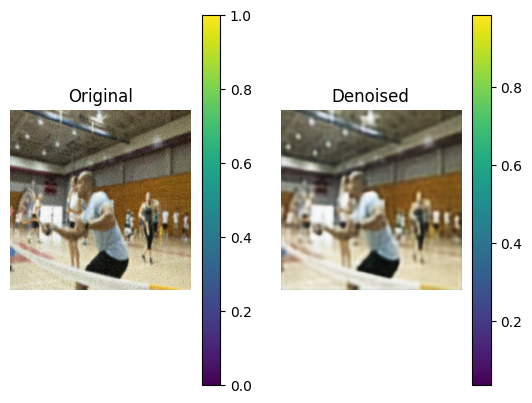

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


array([[0.6511175 , 0.70503366, 0.71279496, ..., 0.7260882 , 0.7001105 ,
        0.5993233 ],
       [0.6652995 , 0.733212  , 0.7341834 , ..., 0.73229426, 0.7182839 ,
        0.64009356],
       [0.7111487 , 0.78824246, 0.785724  , ..., 0.77077574, 0.75549567,
        0.6735044 ],
       ...,
       [0.36887467, 0.31759143, 0.29515922, ..., 0.3962262 , 0.40164512,
        0.41422042],
       [0.3799738 , 0.32404953, 0.28910747, ..., 0.35904437, 0.37524644,
        0.39198557],
       [0.42002454, 0.3941303 , 0.34355402, ..., 0.39417198, 0.42085835,
        0.4068398 ]], dtype=float32)

array([[0.64517206, 0.71392614, 0.73327726, ..., 0.738418  , 0.70056826,
        0.6030155 ],
       [0.72064704, 0.77293956, 0.78888917, ..., 0.7985092 , 0.75566345,
        0.6660727 ],
       [0.74066645, 0.79415804, 0.7983237 , ..., 0.805815  , 0.7657532 ,
        0.68146324],
       ...,
       [0.3520995 , 0.3107599 , 0.29414985, ..., 0.38673934, 0.36961818,
        0.42706123],
       [0.37788123, 0.32454887, 0.30780703, ..., 0.35713604, 0.34797308,
        0.41338164],
       [0.40501213, 0.3346055 , 0.32404047, ..., 0.35685393, 0.3544411 ,
        0.42855814]], dtype=float32)

array([[0.70236427, 0.78400356, 0.79231423, ..., 0.75986344, 0.72909194,
        0.6435945 ],
       [0.74568397, 0.8514791 , 0.85329676, ..., 0.8338615 , 0.81505316,
        0.7117956 ],
       [0.7657861 , 0.8672313 , 0.8753259 , ..., 0.8677991 , 0.85661966,
        0.762145  ],
       ...,
       [0.33331925, 0.3088635 , 0.30580083, ..., 0.38743055, 0.41613486,
        0.41622013],
       [0.35125732, 0.31416595, 0.29939124, ..., 0.3736379 , 0.40052438,
        0.40545723],
       [0.4110564 , 0.37029567, 0.34921324, ..., 0.38640362, 0.39466277,
        0.40239775]], dtype=float32)

(400, 400, 3)
0.01449682
0.9856082
19.67807729781559


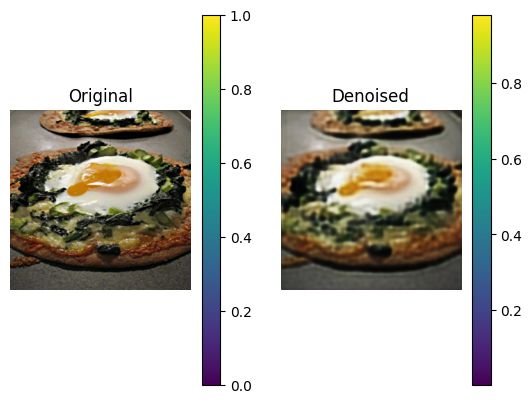

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


array([[0.41318047, 0.3521875 , 0.31347644, ..., 0.1681171 , 0.18835922,
        0.27333498],
       [0.3748651 , 0.33931231, 0.2987713 , ..., 0.16530089, 0.19434173,
        0.24652903],
       [0.3411117 , 0.32488364, 0.29527247, ..., 0.14764951, 0.17181209,
        0.21762666],
       ...,
       [0.14049119, 0.07701868, 0.05508446, ..., 0.15902486, 0.17832276,
        0.20941961],
       [0.19083947, 0.11681066, 0.08104746, ..., 0.15007901, 0.17687155,
        0.21775833],
       [0.29269058, 0.25909907, 0.16552015, ..., 0.23442686, 0.2843808 ,
        0.28507358]], dtype=float32)

array([[0.40414324, 0.35781696, 0.33802778, ..., 0.19547091, 0.20242925,
        0.28728232],
       [0.34811673, 0.31366464, 0.30504462, ..., 0.16524994, 0.16483212,
        0.28718245],
       [0.33266166, 0.31440103, 0.30982932, ..., 0.14545989, 0.13575463,
        0.24989189],
       ...,
       [0.11839525, 0.0566185 , 0.04726157, ..., 0.10363568, 0.09221885,
        0.21878064],
       [0.1604576 , 0.08847214, 0.07645957, ..., 0.10476112, 0.10148852,
        0.23686732],
       [0.23819052, 0.13129486, 0.11677551, ..., 0.1539478 , 0.15280437,
        0.30162653]], dtype=float32)

array([[0.39920285, 0.35495326, 0.32271463, ..., 0.16279827, 0.19323201,
        0.26142746],
       [0.32887644, 0.2781295 , 0.22938202, ..., 0.07528868, 0.10734595,
        0.16882144],
       [0.337426  , 0.29304463, 0.24886566, ..., 0.07721218, 0.10204767,
        0.14785531],
       ...,
       [0.07607119, 0.04480048, 0.03799971, ..., 0.09617321, 0.1183384 ,
        0.15770812],
       [0.10289183, 0.06452485, 0.05290838, ..., 0.09869795, 0.12972015,
        0.1807774 ],
       [0.23570806, 0.15874514, 0.12770933, ..., 0.15574732, 0.18844928,
        0.24186046]], dtype=float32)

(400, 400, 3)
0.006522302
0.9276594
21.33638761005839


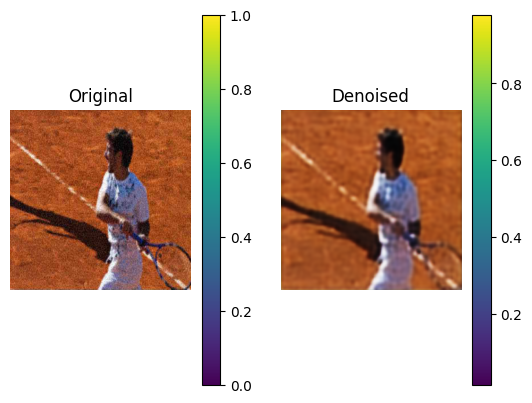

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


array([[0.26911268, 0.18039447, 0.14390597, ..., 0.648016  , 0.6196813 ,
        0.53303576],
       [0.21070817, 0.14269204, 0.1135291 , ..., 0.6640647 , 0.6578856 ,
        0.54965276],
       [0.16931155, 0.1116204 , 0.09007846, ..., 0.6876242 , 0.6754534 ,
        0.56648993],
       ...,
       [0.49298507, 0.496741  , 0.47125983, ..., 0.14737329, 0.16700889,
        0.19311507],
       [0.4874116 , 0.47818908, 0.43218413, ..., 0.13880233, 0.16556078,
        0.20255019],
       [0.4964998 , 0.50497895, 0.45565292, ..., 0.22217084, 0.2741322 ,
        0.2721929 ]], dtype=float32)

array([[0.2609144 , 0.16574897, 0.14480239, ..., 0.5047765 , 0.48571518,
        0.46254477],
       [0.1590364 , 0.10373305, 0.09034205, ..., 0.5361224 , 0.49770936,
        0.49035364],
       [0.14059977, 0.09068689, 0.07904405, ..., 0.50267   , 0.4487431 ,
        0.47691917],
       ...,
       [0.4923239 , 0.47249782, 0.4549527 , ..., 0.07847192, 0.06902006,
        0.19311388],
       [0.5082292 , 0.48292   , 0.4681342 , ..., 0.08416127, 0.08186036,
        0.21614939],
       [0.4847063 , 0.44744673, 0.43870118, ..., 0.13145432, 0.13074824,
        0.2838172 ]], dtype=float32)

array([[0.24922095, 0.15855119, 0.12236829, ..., 0.33052853, 0.34663263,
        0.4310439 ],
       [0.13385484, 0.07326504, 0.05073863, ..., 0.22764617, 0.25354484,
        0.3652065 ],
       [0.12744714, 0.06880399, 0.05302635, ..., 0.21649452, 0.23950641,
        0.35293058],
       ...,
       [0.44899532, 0.42727014, 0.41496727, ..., 0.07196136, 0.09286915,
        0.13385874],
       [0.4646757 , 0.4365851 , 0.4191665 , ..., 0.0766095 , 0.1062744 ,
        0.15818277],
       [0.48036963, 0.4527157 , 0.44106773, ..., 0.13142475, 0.16434774,
        0.2223002 ]], dtype=float32)

(400, 400, 3)
0.0077548437
0.95865065
21.197314921667303


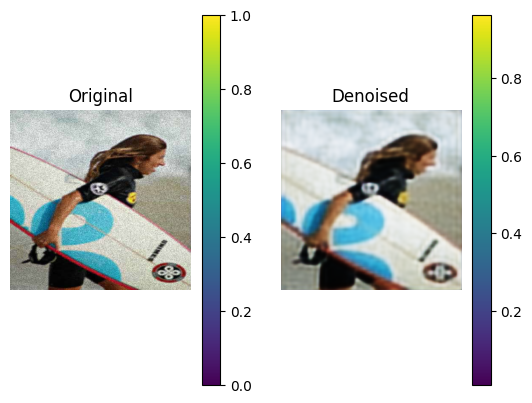

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


array([[0.3466973 , 0.26743838, 0.22970852, ..., 0.5154408 , 0.48650554,
        0.4622858 ],
       [0.31063685, 0.25404486, 0.21753144, ..., 0.47727445, 0.4883144 ,
        0.45588502],
       [0.27956733, 0.24070825, 0.21252829, ..., 0.48830128, 0.4879703 ,
        0.462056  ],
       ...,
       [0.4676481 , 0.4515064 , 0.40788734, ..., 0.44318354, 0.42141715,
        0.4044768 ],
       [0.44587702, 0.40730214, 0.33893737, ..., 0.37320337, 0.38197115,
        0.3717281 ],
       [0.46817237, 0.459782  , 0.38591555, ..., 0.39574248, 0.42065725,
        0.38119563]], dtype=float32)

array([[0.34378144, 0.27041754, 0.24755381, ..., 0.45858365, 0.4289108 ,
        0.41170964],
       [0.269064  , 0.20196226, 0.19084688, ..., 0.44992954, 0.4046948 ,
        0.4271455 ],
       [0.26305842, 0.21472336, 0.20404325, ..., 0.43437436, 0.37283865,
        0.39305717],
       ...,
       [0.46506456, 0.4162793 , 0.38356087, ..., 0.40264642, 0.3653779 ,
        0.41926327],
       [0.4750812 , 0.40443859, 0.37121713, ..., 0.36303577, 0.32883212,
        0.4033305 ],
       [0.45465195, 0.3787799 , 0.3611959 , ..., 0.33468148, 0.31742337,
        0.41443425]], dtype=float32)

array([[0.36271057, 0.31133446, 0.27003434, ..., 0.4125221 , 0.40954328,
        0.4487906 ],
       [0.27473885, 0.22880992, 0.17884763, ..., 0.3326738 , 0.34601894,
        0.40020975],
       [0.28377044, 0.24993603, 0.21151328, ..., 0.3896974 , 0.40183395,
        0.43026176],
       ...,
       [0.45179147, 0.42133415, 0.37931904, ..., 0.41188473, 0.4318375 ,
        0.42764938],
       [0.4507498 , 0.40220618, 0.3562075 , ..., 0.3937781 , 0.40376034,
        0.39540985],
       [0.45745322, 0.4135009 , 0.38218242, ..., 0.3799504 , 0.3763223 ,
        0.37360814]], dtype=float32)

(400, 400, 3)
0.016761748
0.98286843
19.537481426948812


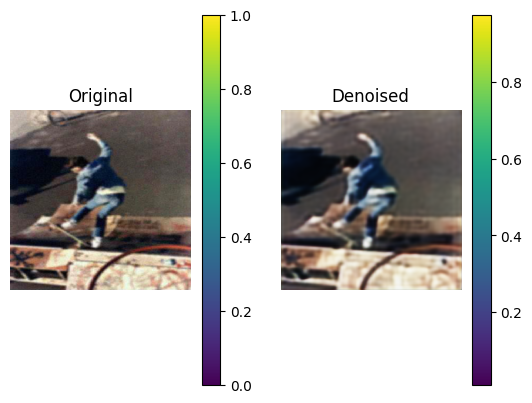

In [9]:
# Predict on the first 10 test images.
for i in range(10):
    # Get the next image from the generator
    image = next(test_noisy_gen)
    image_clean = next(test_clear_gen)
    # Predict the denoised image
    denoised_image = autoencoder.predict(image)

    # denoised_image = denoised_image - denoised_image.min()
    # denoised_image = denoised_image / denoised_image.max()

    # denoised_image = denoised_image.astype('float32') * 255.0
    # denoised_image = denoised_image.astype('uint8')
    image1 = denoised_image[0]

    display(image1[:,:,0])
    display(image1[:,:,1])
    display(image1[:,:,2])

    print(denoised_image[0].shape)
    print(denoised_image[0].min())
    print(denoised_image[0].max())
    # denoised_image = (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min())
    # Display the original (noisy) and denoised images

    print(calculate_psnr(image_clean[0], denoised_image[0]))

    fig, ax = plt.subplots(1, 2)
    
    im1 = ax[0].imshow(image[1])
    ax[0].set_title('Original')
    ax[0].axis('off')
    fig.colorbar(im1, ax=ax[0])
    
    im2 = ax[1].imshow(denoised_image[1])
    ax[1].set_title('Denoised')
    ax[1].axis('off')
    fig.colorbar(im2, ax=ax[1])

    plt.show()